In [1]:
# Load in required libraries
import requests, sys
import pandas as pd
import numpy as np
import re
import os
from ast import literal_eval
import json
import pysam
import matplotlib.pyplot as plt
from collections import defaultdict
from Bio.Seq import Seq

In [2]:
# Query Ensembl REST API for information about genes and their canonical transcript
def ensembl_rest_genes(batch):
    server = "https://rest.ensembl.org"
    ext = "/lookup/symbol/homo_sapiens"
    headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
    r = requests.post(server+ext, headers=headers, data=json.dumps({"symbols": batch}))
     
    if not r.ok:
      r.raise_for_status()
      sys.exit()
     
    ensembl_genes = r.json()

    # Reformat returned json as pandas dataframe with required columns
    gene_table = pd.DataFrame(columns = ["display_name","id","seq_region_name","strand","start","end","canonical_transcript"])

    for gene in ensembl_genes: # Extract required information about each gene
        start = ensembl_genes[gene]['start']
        end = ensembl_genes[gene]['end']
        canonical_transcript = ensembl_genes[gene]['canonical_transcript']
        id = ensembl_genes[gene]['id']
        seq_region_name = ensembl_genes[gene]['seq_region_name']
        strand = ensembl_genes[gene]['strand']
        display_name = ensembl_genes[gene]['display_name']
        gene_info = pd.DataFrame([[display_name, id, seq_region_name, strand, start, end, canonical_transcript]], columns = gene_table.columns)

        # Add gene info to gene table
        gene_table = pd.concat([gene_table, gene_info], ignore_index = True)
    
    return(gene_table)

In [3]:
# Query Ensembl REST API for information about transcripts and their exons
def ensembl_rest_transcripts(transcripts):
    server = "https://rest.ensembl.org"
    ext = "/lookup/id"
    headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
    r = requests.post(server+ext, headers=headers, data=json.dumps({"ids": transcripts}), params="expand=1")
     
    if not r.ok:
      r.raise_for_status()
      sys.exit()
     
    ensembl_transcripts = r.json()
    return(ensembl_transcripts)

In [4]:
# Calculate coverage (number of cell barcodes aligning to each position) along a specific gene based on the start and end positions reported by ENSEMBL
def calculate_coverage(sample, seq_type, barcodes, gene, c_some, tx_start, tx_end, bam):
    
    # Account for differences in BAM tags between 10x and Kinnex
    if seq_type == "10x":
        umi_tag = "UB"
    elif seq_type == "Kx":
        umi_tag = "XM"

    all_keys = set()
    pos_keys = defaultdict(set)

    # For each read that aligns to the genomic region of the gene, extract the CB tag and add it to an 'all_keys' set
    for rec in bam.fetch(reference=c_some,
                         start=tx_start,
                         end=tx_end):
        if rec.has_tag('CB') and rec.has_tag(umi_tag) and rec.get_tag('CB') in barcodes:
            key = rec.get_tag('CB')
            all_keys.add(key)

            # For each position in read, assign barcodes which mapped to the position to a dictionary
            for pos in rec.get_reference_positions():
                pos_keys[pos].add(key)
    
    df = pd.DataFrame([[position, (len(cell_coverage)/len(barcodes)), (len(all_keys)/len(barcodes)) * 100] for position, cell_coverage in sorted(pos_keys.items())],
                      columns=['genomic_position','proportional_coverage','percent_gene_expression'])
    # Add useful info before returning dataframe
    df['method'] = seq_type
    df['sample'] = sample
    df['gene'] = gene
    
    return df

In [5]:
# Convert barcodes and calculate overlap between technologies
def convert_barcodes(barcodes_10x, barcodes_kx):
    # Strip appendix from barcodes
    clean_10x = [barcode[:16] for barcode in barcodes_10x] 
    clean_kx = [barcode[:16] for barcode in barcodes_kx] 
    
    converted_10x = [str(Seq(barcode).reverse_complement()) for barcode in clean_10x]
    common_barcodes_kx = set(converted_10x).intersection(set(clean_kx))
    common_barcodes_10x = [str(Seq(barcode).reverse_complement()) for barcode in common_barcodes_kx]

    return pd.DataFrame({'10x': list(common_barcodes_10x),
                         'Kx' : list(common_barcodes_kx)})

In [6]:
# Define gene list to query
script_parameters = pd.read_csv("script_parameters.tsv", sep="\t")
input_genes = pd.read_csv(script_parameters.loc[2, 'value'], sep='\t')
gene_list = pd.read_csv(script_parameters.loc[2,'value'], sep='\t')['gene'].values.tolist()

# Check if gene already queried in 'ensembl_genes.csv' - if file does not exist, it will be created with predefined columns
if not os.path.exists('ensembl_genes.csv'):
    with open('ensembl_genes.csv', 'w') as file:
        file.write('display_name,id,seq_region_name,strand,start,end,canonical_transcript,exon_positions' + '\n') # Later appending step was inserting on header row when new line was not specified at the end

df = pd.read_csv('ensembl_genes.csv')
genes = df['display_name'].values.tolist() # Extract gene names
new_genes = [gene for gene in gene_list if gene not in genes] # Extract genes which haven't already been analysed

if len(new_genes) > 0: # Only run below code if there are new genes to query
    # Process gene list in blocks of 1000 due to constraints of Ensembl API
    chunk_size = 1000 # Maximum POST size
    ensembl_genes = pd.DataFrame()

    for i in range(0, len(new_genes), chunk_size):
        gene_block = new_genes[i:i + chunk_size]
        block_results = ensembl_rest_genes(gene_block)
        ensembl_genes = pd.concat([ensembl_genes, block_results], ignore_index=True)
    
    ensembl_genes['exon_positions'] = '' # Create empty column to store exon positions
    
    # Process genes to extract exon information about canonical transcript 
    transcripts = ensembl_genes['canonical_transcript']
    cleaned_transcripts = [re.sub(r'\..*', '', transcript) for transcript in ensembl_genes['canonical_transcript']] # Remove version number as endpoint doesn't support it
    ensembl_transcripts = ensembl_rest_transcripts(cleaned_transcripts)
    
    for transcript in ensembl_transcripts:
        exon_starts = []
        exon_ends = []
        for exon in ensembl_transcripts[transcript]['Exon']:
            exon_starts.append(exon['start']) 
            exon_ends.append(exon['end'])
    
        exon_ranges = []
        
        for start, end in zip(exon_starts, exon_ends):
            exon_ranges.extend(range(start, end))
            
        # Extract row number of gene 
        index = ensembl_genes[ensembl_genes['canonical_transcript'].str.contains(transcript)].index.tolist()[0]
    
        # Add exon positions to ensembl_genes df
        ensembl_genes["exon_positions"][index] = exon_ranges
    
    # Save ensembl_genes as 'ensembl_genes.csv'
    ensembl_genes.to_csv('ensembl_genes.csv', index=False, mode='a', header=False) # Don't overwrite genes which were already processed


In [7]:
# Calculate coverage for each gene and save results for faster reloading of gene
ensembl_genes = pd.read_csv('ensembl_genes.csv') # Load in ENSEMBL information about genes

# Check to see if any coverage data exists and read it in if it does; If it doesn't, it will create an empty file
if not os.path.exists('coverage_results.csv'):
    with open('coverage_results.csv', 'w') as file:
        file.write('genomic_position,proportional_coverage,percent_gene_expression,method,sample,gene')

gene_cov = pd.read_csv('coverage_results.csv')

# Read in input genes
input_genes = pd.read_csv(script_parameters.loc[2, 'value'], sep='\t', dtype=str)
input_genes.set_index(input_genes.columns[0], inplace=True)
input_genes.index.name = None

# Don't run coverage script for genes already processed
unprocessed_genes = set(input_genes.index.tolist()).difference(set(gene_cov['gene'].unique().tolist()))

# Check to see if 10x and Kinnex data are present
if len(script_parameters.loc[0,'value'].split(',')) == 2:

    # Import barcodes and convert them
    sample_barcodes = script_parameters.loc[1,'value'].split(',')
    for file in sample_barcodes:
        if re.search("10x", file):
            barcodes_10x = pd.read_csv(file, sep='\t', header=None)[0]
        elif re.search("Kx", file):
            barcodes_Kx = pd.read_csv(file, sep='\t', header=None)[0]
    barcodes = convert_barcodes(barcodes_10x, barcodes_Kx)
    barcodes['10x'] = barcodes['10x'] + "-1" #  Append suffix to 10x barcodes (the BAM files have -1 in their tags)
    
    for i in range(0,2):

        platform = script_parameters.loc[3,'value'].split(',')[i]

        sample_barcodes = barcodes[platform].tolist()
        sample_bam = pysam.AlignmentFile(script_parameters.loc[0,'value'].split(',')[i])
        
        for gene in unprocessed_genes:
            index = ensembl_genes[ensembl_genes['display_name'].str.contains(gene)].index.tolist()[0]
            
            cov_df = calculate_coverage(script_parameters.loc[4,'value'],                         # sample
                                        platform,                                                 # seq_type
                                        sample_barcodes,                                          # barcodes
                                        gene,                                                     # gene
                                        "chr" + str(ensembl_genes["seq_region_name"][index]),     # c_some
                                        ensembl_genes["start"][index],                            # tx_start
                                        ensembl_genes["end"][index],                              # tx_end
                                        sample_bam)                                               # bam
        
            gene_cov = pd.concat([gene_cov, cov_df], ignore_index = True)

gene_cov.to_csv('dual_coverage_results.csv', index=False)

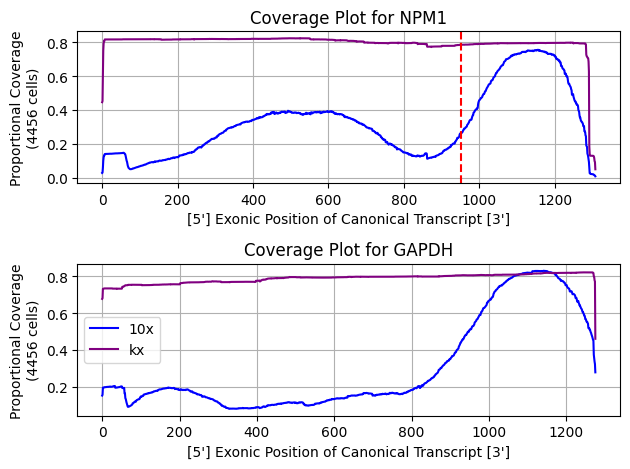

In [8]:
# Create coverage plots and save all in one figure
genes_covered = gene_cov['gene'].unique()

fig, axes = plt.subplots(len(genes_covered))

for gene in genes_covered:
    mutation_list = None # Assume there is no mutational info to start

    # Import mutational data if present
    if pd.notna(input_genes.loc[gene, 'mutations']):
        # Perform the following if there is mutational data
        mutation_list = input_genes.loc[gene, 'mutations'].split(',')

    gene_exons = literal_eval(ensembl_genes[ensembl_genes['display_name'] == gene]['exon_positions'].tolist()[0])
    sub_cov = gene_cov.loc[(gene_cov['gene'] == gene) & (gene_cov['genomic_position'].isin(gene_exons))].reset_index(drop=True)

    i = ensembl_genes[ensembl_genes['display_name'] == gene].index[0]
    
    # Plot dual data mode
    if len(script_parameters.loc[0,'value'].split(',')) == 2:
        plot_sub_cov = pd.merge(sub_cov[sub_cov["method"] == "10x"], 
                                sub_cov[sub_cov["method"] == "Kx"], 
                                on='genomic_position', suffixes=('_10x', '_kx'))
        
        axes[i].plot(plot_sub_cov.index, plot_sub_cov['proportional_coverage_10x'], color='blue', label='10x')
        axes[i].plot(plot_sub_cov.index, plot_sub_cov['proportional_coverage_kx'], color='purple', label='kx')

        if mutation_list != None:
            for mutation in mutation_list:
                axes[i].axvline(plot_sub_cov.index[plot_sub_cov["genomic_position"] == int(mutation)].tolist()[0], 0, 1, linestyle = "--", color = "red")

    axes[i].set_title(f"Coverage Plot for {gene}")
    axes[i].grid()
    axes[i].set_xlabel("[5'] Exonic Position of Canonical Transcript [3']")
    axes[i].set_ylabel(f'Proportional Coverage\n({len(sample_barcodes)} cells)')

plt.tight_layout()
plt.legend()
plt.savefig(f"{sub_cov['sample'].unique()[0]}_coverage_plots.jpg")